# DS3-2 EDA "Median Prices of Existing Single Family Homes" dataset from the California Association of Realtors.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from scipy import stats
from statsmodels.tsa.stattools import adfuller

In [2]:
# Enforce copy-on-write behavior for pandas DataFrames
pd.options.mode.copy_on_write = True

# Folder Organization

In [ ]:
# Read in the data file
# Load and clean DS3-2: Median Prices of Existing Single Family Homes

parent_dir = Path.cwd().parent
filepath = parent_dir / "data" / "ds3-2.csv"  # change path if your file is elsewhere
df = pd.read_csv(filepath)

# Convert Mon-Yr to datetime
df["date"] = pd.to_datetime(df["Mon-Yr"], format="%b-%y", errors="coerce")
df = df.sort_values("date")

# Identify value columns: all except Mon-Yr, date, and obvious junk
cols_to_skip = ["Mon-Yr", "date", "Unnamed: 55", "Cond"]
value_cols = [c for c in df.columns if c not in cols_to_skip]

# Clean currency strings: "$194,952" -> 194952.0
for col in value_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Set date as index for time-series work
df = df.set_index("date")

# check
df[value_cols].head()


,CA,Alameda,Amador,Butte,Calaveras,Contra-Costa,Del Norte,El Dorado,Fresno,Glenn,...,Yolo,Yuba,Condo,LA Metro,Central Coast,Central Valley,Far North,Inland Empire,S.F. Bay Area,SoCal
date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,194952,226149,NaN,102143,NaN,NaN,NaN,NaN,82083,NaN,...,NaN,NaN,141519,203390,NaN,NaN,NaN,NaN,227366,NaN
1990-02-01,196273,219306,NaN,83333,NaN,NaN,NaN,NaN,87187,NaN,...,NaN,NaN,144965,211024,NaN,NaN,NaN,NaN,234739,NaN
1990-03-01,194856,225162,NaN,100000,NaN,NaN,NaN,NaN,83889,NaN,...,NaN,NaN,141132,209286,NaN,NaN,NaN,NaN,235337,NaN
1990-04-01,196111,229333,NaN,108000,NaN,NaN,NaN,NaN,85428,NaN,...,NaN,NaN,145707,210302,NaN,NaN,NaN,NaN,233178,NaN
1990-05-01,195281,232291,NaN,100000,NaN,NaN,NaN,NaN,88749,NaN,...,NaN,NaN,146060,210148,NaN,NaN,NaN,NaN,235881,NaN


# Insight on why ds3
- ds3 covers more than 1 decade of data (from 1990 onward)
- its broken down by county/region, which lets us compare different parts of CA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 64 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Mon-Yr           429 non-null    object 
 1   CA               429 non-null    object 
 2   Alameda          429 non-null    object 
 3   Amador           259 non-null    object 
 4   Butte            429 non-null    object 
 5   Calaveras        297 non-null    object 
 6   Contra-Costa     237 non-null    object 
 7   Del Norte        201 non-null    object 
 8   El Dorado        201 non-null    object 
 9   Fresno           429 non-null    object 
 10  Glenn            237 non-null    object 
 11  Humboldt         429 non-null    object 
 12  Imperial         81 non-null     object 
 13  Kern             429 non-null    object 
 14  Kings            237 non-null    object 
 15  Lake             381 non-null    object 
 16  Lassen           117 non-null    object 
 17  Los Angeles     

In [16]:
df.shape

(429, 64)

In [8]:
print(df.isna().sum().sort_values(ascending=False).head(15))

Unnamed: 55       429
Trinity           349
Imperial          348
Lassen            312
Far North         312
Plumas            284
El Dorado         228
Del Norte         228
Yolo              228
Central Valley    228
Madera            216
Tehama            213
Yuba              195
Sutter            195
Glenn             192
dtype: int64


In [9]:
regions = ["CA",
           "Los Angeles",
           "Orange"
           ]

available_regions = [r for r in regions if r in df.columns]
print("Available regions in this file:", available_regions)

desc = df[available_regions].describe().T
desc

Available regions in this file: ['CA', 'Los Angeles', 'Orange']


,count,unique,top,freq
CA,429,426,"$549,460",2
Los Angeles,429,429,"$215,338",1
Orange,429,403,"$1,100,000",5


# Method to compute returns/changes

In [4]:
# compute monthly price changes (returns)

def compute_returns(df: pd.DataFrame, region: str, method: str = "log") -> pd.Series:
    """
    Compute monthly price changes for a given region.

    method="log": log returns: log(P_t) - log(P_{t-1})
    method="pct": percent changes: (P_t - P_{t-1}) / P_{t-1}
    """
    if region not in df.columns:
        raise ValueError(f"Region '{region}' not found in columns")

    series = df[region].dropna()

    if method == "log":
        returns = np.log(series).diff()
    elif method == "pct":
        returns = series.pct_change()
    else:
        raise ValueError("method must be 'log' or 'pct'")

    return returns.dropna()



In [5]:
ca_returns = compute_returns(df, "CA", method="log")


## func to compare actual returns vs normal distributions

In [ ]:
# plot distribution of returns vs normal for a single region

def plot_returns_vs_normal(df: pd.DataFrame, region: str, method: str = "log"):
    """
    For the given region, compute monthly returns and:
      - print mean, std, skewness, and excess kurtosis
      - plot histogram with fitted normal PDF
      - plot Q-Q plot vs normal

    This is how we visually and statistically compare:
    "Are price changes normal or fat-tailed?"
    """
    returns = compute_returns(df, region, method=method)

    mean = returns.mean()
    std = returns.std()
    skew = returns.skew()
    kurt = returns.kurtosis()  

    print(f"=== {region} {method} returns ===")
    print(f"n = {len(returns)}")
    print(f"Mean: {mean:.6f}")
    print(f"Std: {std:.6f}")
    print(f"Skewness: {skew:.3f}")
    print(f"Excess Kurtosis: {kurt:.3f}\n")

    # Histogram with normal overlay
    plt.figure(figsize=(9,5))
    sns.histplot(returns, stat="density", bins=40)

    x = np.linspace(returns.min(), returns.max(), 300)
    pdf = stats.norm.pdf(x, mean, std)
    plt.plot(x, pdf)  # "normal" curve

    plt.title(f"{region} Monthly {method} Returns\nHistogram vs Normal PDF")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.show()

    # Q-Q plot against normal
    plt.figure(figsize=(6,6))
    stats.probplot(returns, dist="norm", plot=plt)
    plt.title(f"{region} Monthly {method} Returns\nQ-Q Plot vs Normal")
    plt.show()


=== CA log returns ===
n = 428
Mean: 0.003531
Std: 0.032359
Skewness: 0.036
Excess Kurtosis: 1.640



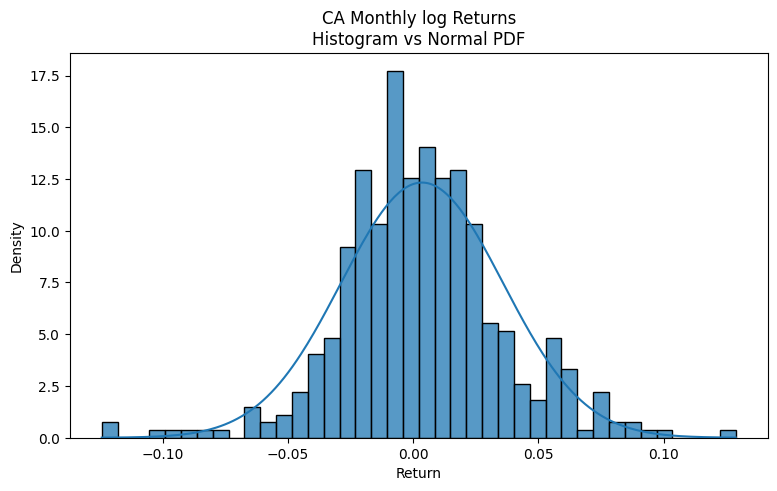

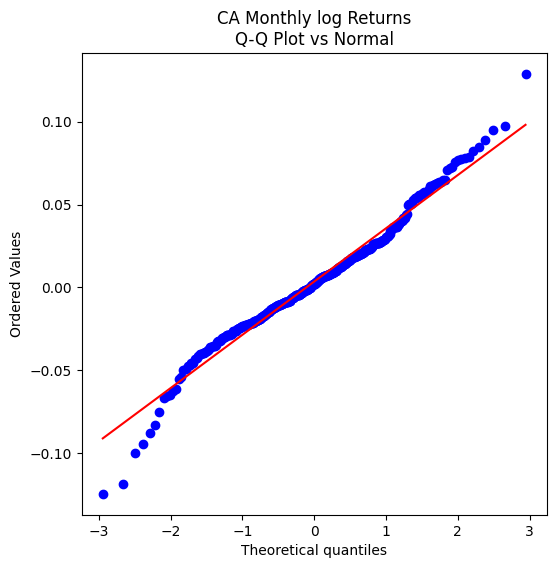

In [9]:
plot_returns_vs_normal(df, "CA", method="log")

## All regions

Total number of return observations across all regions: 20998
Combined returns - Mean: 0.003677, Std: 0.093412
Skewness: 0.484, Excess Kurtosis: 31.475



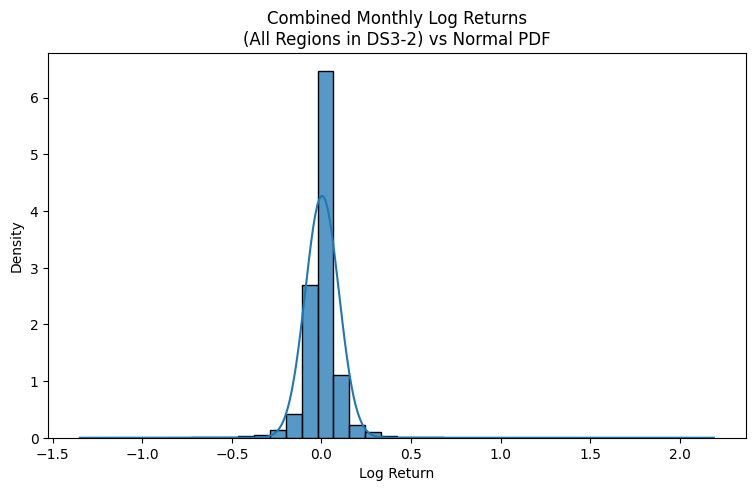

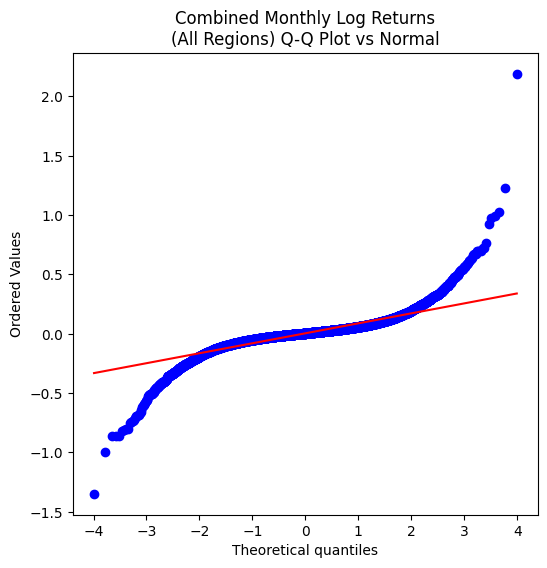

In [ ]:
# Combined distribution of returns across all regions

all_returns = []

for col in value_cols:  # from the cleaning cell
    # Skip columns that are almost empty
    if df[col].notna().sum() < 5:
        continue
    r = compute_returns(df, col, method="log")
    all_returns.append(r)

all_returns = pd.concat(all_returns)
print("Total number of return observations across all regions:", len(all_returns))

mean_all = all_returns.mean()
std_all = all_returns.std()
skew_all = all_returns.skew()
kurt_all = all_returns.kurtosis()

print(f"Combined returns - Mean: {mean_all:.6f}, Std: {std_all:.6f}")
print(f"Skewness: {skew_all:.3f}, Excess Kurtosis: {kurt_all:.3f}\n")

# Histogram + normal overlay for all regions
plt.figure(figsize=(9,5))
sns.histplot(all_returns, stat="density", bins=40)

x = np.linspace(all_returns.min(), all_returns.max(), 300)
pdf = stats.norm.pdf(x, mean_all, std_all)
plt.plot(x, pdf)

plt.title("Combined Monthly Log Returns\n(All Regions in DS3-2) vs Normal PDF")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.show()

# Q-Q plot for all regions
plt.figure(figsize=(6,6))
stats.probplot(all_returns, dist="norm", plot=plt)
plt.title("Combined Monthly Log Returns\n(All Regions) Q-Q Plot vs Normal")
plt.show()


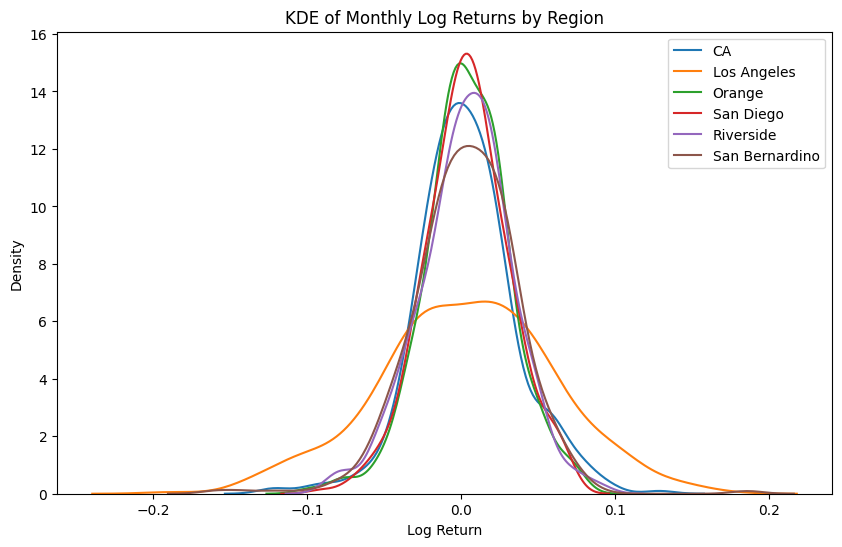

In [ ]:
# KDE comparison across multiple regions

regions_to_compare = ["CA", "Los Angeles", "Orange", "San Diego", "Riverside", "San Bernardino"]
regions_to_compare = [r for r in regions_to_compare if r in df.columns]

plt.figure(figsize=(10,6))

for r in regions_to_compare:
    ret = compute_returns(df, r, method="log")
    sns.kdeplot(ret, label=r)

plt.title("KDE of Monthly Log Returns by Region")
plt.xlabel("Log Return")
plt.legend()
plt.show()


# Distribution plots + normal fit

=== CA log returns ===
n = 428
Mean: 0.003531
Std: 0.032359
Skewness: 0.036
Excess Kurtosis: 1.640


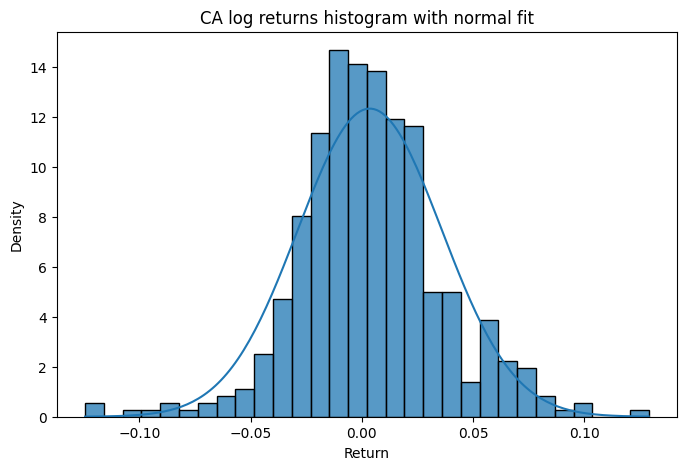

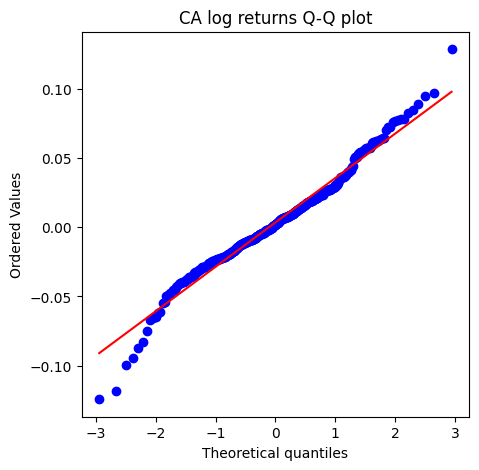

In [13]:
def analyze_distribution(df: pd.DataFrame, region: str, method: str = "log"):
    returns = compute_returns(df, region, method=method)

    mean = returns.mean()
    std = returns.std()
    skew = returns.skew()
    kurt = returns.kurtosis()  # excess kurtosis

    print(f"=== {region} {method} returns ===")
    print(f"n = {len(returns)}")
    print(f"Mean: {mean:.6f}")
    print(f"Std: {std:.6f}")
    print(f"Skewness: {skew:.3f}")
    print(f"Excess Kurtosis: {kurt:.3f}")

    # Histogram with normal pdf overlay
    plt.figure(figsize=(8, 5))
    sns.histplot(returns, stat="density", bins=30)
    x = np.linspace(returns.min(), returns.max(), 200)
    pdf = stats.norm.pdf(x, mean, std)
    plt.plot(x, pdf)
    plt.title(f"{region} {method} returns histogram with normal fit")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.show()

    # Q-Q plot vs normal
    plt.figure(figsize=(5, 5))
    stats.probplot(returns, dist="norm", plot=plt)
    plt.title(f"{region} {method} returns Q-Q plot")
    plt.show()

# Example for statewide CA
analyze_distribution(df, "CA", method="log")


=== Los Angeles log returns ===
n = 428
Mean: 0.003548
Std: 0.056960
Skewness: -0.119
Excess Kurtosis: 0.117


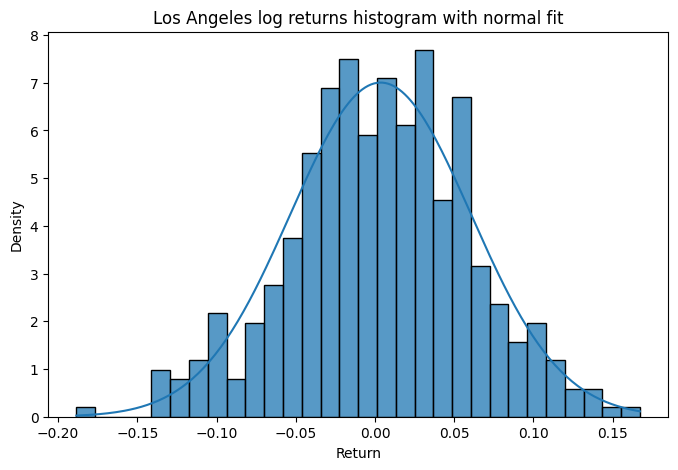

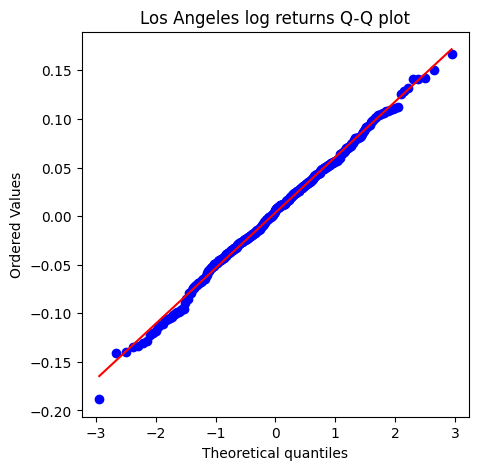

=== San Diego log returns ===
n = 428
Mean: 0.003977
Std: 0.027398
Skewness: -0.086
Excess Kurtosis: 0.272


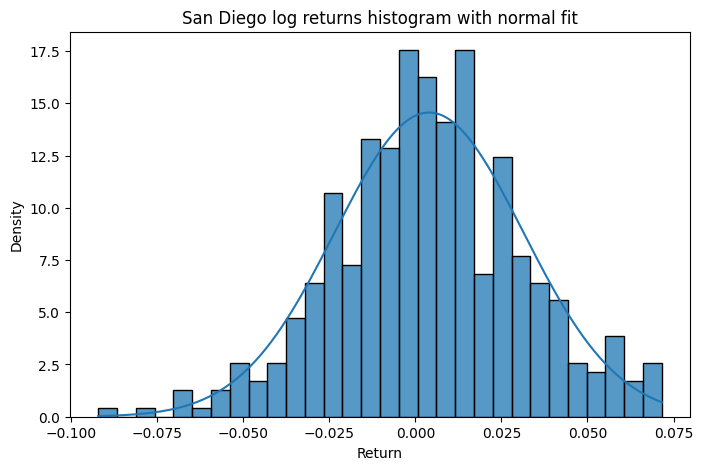

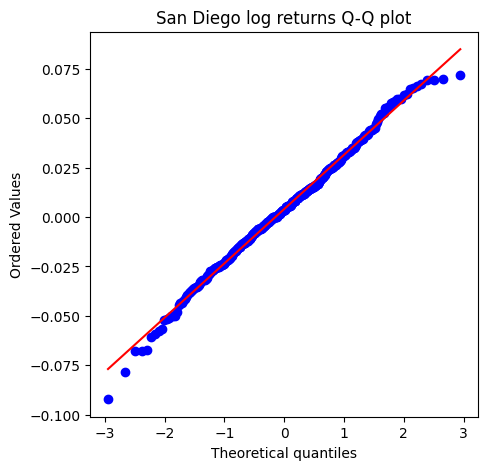

=== Orange log returns ===
n = 428
Mean: 0.004209
Std: 0.027632
Skewness: -0.239
Excess Kurtosis: 0.920


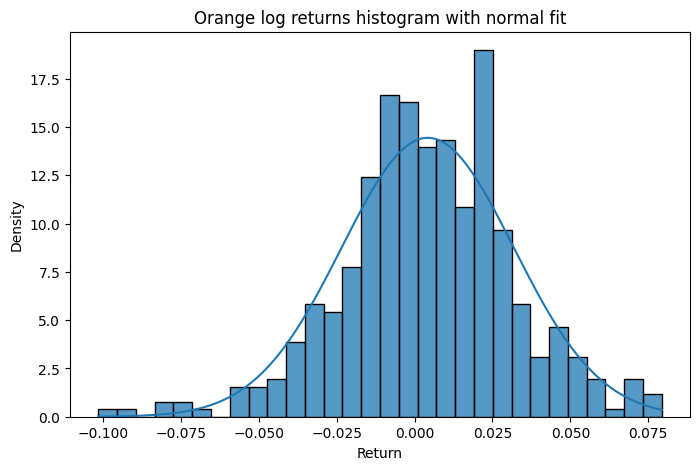

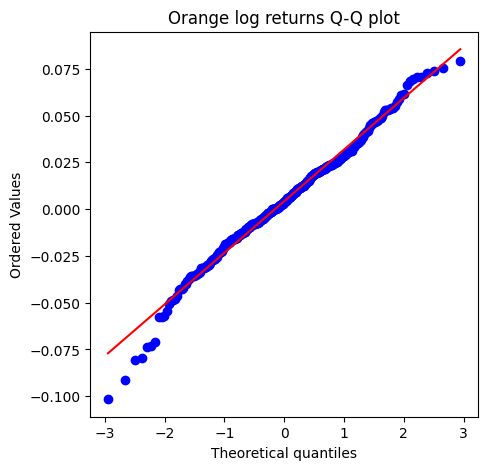

In [14]:
for r in ["Los Angeles", "San Diego", "Orange"]:
    if r in df.columns:
        analyze_distribution(df, r, method="log")
